<a href="https://colab.research.google.com/github/Philewj/CS-695-CNN-Implementation-MNIST/blob/main/Cs695_Project_Malware_detection_Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malware Detection Model

In [12]:
# !wget "https://drive.google.com/uc?id=1YQiwQ2XmCNQoQv5G898cngZYuv00gW47&confirm=t"
# !mv "$(ls -Art | head -1)" mal.zip

!pip install gdown
#upgrade
!pip install --upgrade gdown

import gdown
# a file
url = "https://drive.google.com/uc?id=1YQiwQ2XmCNQoQv5G898cngZYuv00gW47"
output = "mal.zip"
gdown.download(url, output)

!unzip -o mal.zip
!rm mal_data/train/.DS_Store
!rm mal_data/test/.DS_Store

Downloading...
From (original): https://drive.google.com/uc?id=1YQiwQ2XmCNQoQv5G898cngZYuv00gW47
From (redirected): https://drive.google.com/uc?id=1YQiwQ2XmCNQoQv5G898cngZYuv00gW47&confirm=t&uuid=e92ab8f8-701f-4e10-b0de-a874988b90aa
To: /content/mal.zip
100%|██████████| 2.44G/2.44G [00:22<00:00, 109MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: mal_data/train/Zbot/49f9785d5a42b3daa95d7d91ab077e669f7116c8.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._49f9785d5a42b3daa95d7d91ab077e669f7116c8.exe  
  inflating: mal_data/train/Zbot/daf40516a7c465ebbcaea190707a04bf6af1a2e5.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._daf40516a7c465ebbcaea190707a04bf6af1a2e5.exe  
  inflating: mal_data/train/Zbot/42547c95702e0c5c846e4e5ecac6db6ac8c22175.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._42547c95702e0c5c846e4e5ecac6db6ac8c22175.exe  
  inflating: mal_data/train/Zbot/39940afa60287af35d90db68fc6396d0c20b74d0.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._39940afa60287af35d90db68fc6396d0c20b74d0.exe  
  inflating: mal_data/train/Zbot/d7c51263bd3beec0fcefa2d94589530450b5e1bd.exe  
  inflating: __MACOSX/mal_data/train/Zbot/._d7c51263bd3beec0fcefa2d94589530450b5e1bd.exe  
  inflating: mal_data/train/Zbot/21891ae5ca1d7146a8df57aa7c89b7234b099ff7.exe  
  inflating: _

In [13]:
import os
import pickle

import numpy as np

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
import os
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folders in a dataset.
    See :class:`DatasetFolder` for details.
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

_,class_to_idx = find_classes("mal_data/train")


class MalwareDataset(Dataset):
    def __init__(self, data_path, input_length = 4096, transform=False):
        self.data_path = data_path
        self.input_length = input_length
        _,self.class_to_idx = find_classes(data_path)
        self.malware_files = []
        available_classes = set()
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(data_path, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, class_index
                    self.malware_files.append(item)

    def __getitem__(self, index):
        item = self.malware_files[index]
        with open(item[0], "rb") as f:
            tmp = [i+1 for i in f.read()[:self.input_length]]
            tmp = tmp+[0]*(self.input_length-len(tmp))
        return np.array(tmp), item[1]

    def __len__(self):
        return len(self.malware_files)



In [14]:
import torch
from torch import nn
from torch.nn import functional as F


# neural network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.classifier = nn.Sequential(
            nn.Conv1d(1,4,19,5),
            nn.MaxPool1d(4),
            nn.Flatten(),
            nn.Linear(48, 6)
        )

    def forward(self, x):
        out = self.classifier(x)

        return out


model=ConvNet()
model.cuda()
model.train()


lr=0.001
num_epochs=10
batch_size = 16
input_len = 256 # Number of bytes read from application files (.exe)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_data = MalwareDataset("mal_data/train",input_length = input_len)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = MalwareDataset("mal_data/test",input_length = input_len)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

loss_list = []
acc_list = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (samples, labels) in enumerate(train_loader):
    samples = samples.type(torch.FloatTensor).cuda()
    labels = labels.cuda()

    outputs = model(samples.unsqueeze(1))

    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i%200 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))



Epoch [1/10], Step [0/437], Loss: 67.4275, Accuracy: 0.00%
Epoch [1/10], Step [200/437], Loss: 3.8201, Accuracy: 56.25%
Epoch [1/10], Step [400/437], Loss: 2.4077, Accuracy: 75.00%
Epoch [2/10], Step [0/437], Loss: 0.2047, Accuracy: 93.75%
Epoch [2/10], Step [200/437], Loss: 1.3915, Accuracy: 68.75%
Epoch [2/10], Step [400/437], Loss: 1.8971, Accuracy: 68.75%
Epoch [3/10], Step [0/437], Loss: 0.6864, Accuracy: 87.50%
Epoch [3/10], Step [200/437], Loss: 0.5920, Accuracy: 87.50%
Epoch [3/10], Step [400/437], Loss: 0.7422, Accuracy: 87.50%
Epoch [4/10], Step [0/437], Loss: 0.6806, Accuracy: 68.75%
Epoch [4/10], Step [200/437], Loss: 0.8687, Accuracy: 87.50%
Epoch [4/10], Step [400/437], Loss: 0.6482, Accuracy: 81.25%
Epoch [5/10], Step [0/437], Loss: 0.4590, Accuracy: 87.50%
Epoch [5/10], Step [200/437], Loss: 1.0534, Accuracy: 81.25%
Epoch [5/10], Step [400/437], Loss: 0.2247, Accuracy: 87.50%
Epoch [6/10], Step [0/437], Loss: 0.6407, Accuracy: 81.25%
Epoch [6/10], Step [200/437], Loss: 

In [15]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for samples, labels in test_loader:
      samples = samples.type(torch.FloatTensor).cuda()
      labels = labels.cuda()

      outputs = model(samples.unsqueeze(1))
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the test samples: {} %'.format((correct / total) * 100))

Accuracy of the model on the test samples: 92.31026412571046 %


Text(0.5, 1.0, 'loss')

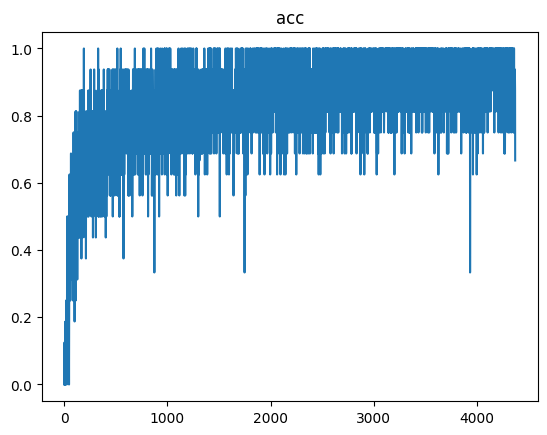

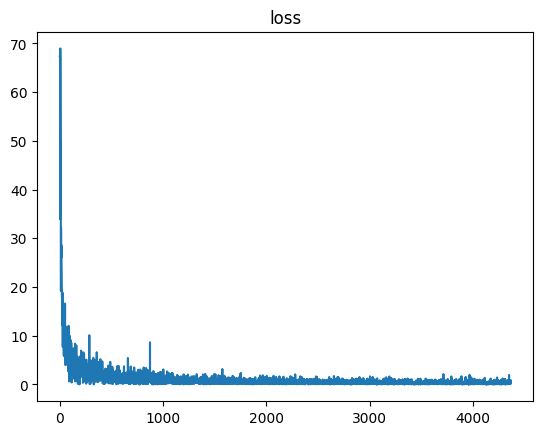

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(acc_list)
plt.title('acc')

plt.figure()
plt.plot(loss_list)
plt.title('loss')



# Adversarial Attacks

In [11]:
!pip install torchattacks

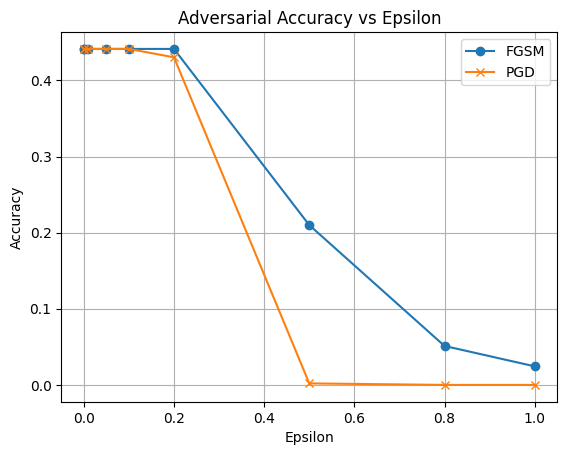

In [17]:

import torchattacks

epsilons = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0]
fgsm_accuracies = []
pgd_accuracies = []

model.eval()
for eps in epsilons:
    # FGSM
    atk_fgsm = torchattacks.FGSM(model, eps=eps)
    correct_fgsm = 0
    total = 0
    for samples, labels in test_loader:
        samples = samples.type(torch.FloatTensor).cuda()
        labels = labels.cuda()
        adv_samples = atk_fgsm(samples.unsqueeze(1), labels)
        outputs = model(adv_samples)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_fgsm += (predicted == labels).sum().item()
    fgsm_accuracies.append(correct_fgsm / total)

    # PGD
    atk_pgd = torchattacks.PGD(model, eps=eps, alpha=eps/4, steps=10)
    correct_pgd = 0
    total = 0
    for samples, labels in test_loader:
        samples = samples.type(torch.FloatTensor).cuda()
        labels = labels.cuda()
        adv_samples = atk_pgd(samples.unsqueeze(1), labels)
        outputs = model(adv_samples)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_pgd += (predicted == labels).sum().item()
    pgd_accuracies.append(correct_pgd / total)

# Plotting
plt.figure()
plt.plot(epsilons, fgsm_accuracies, marker='o', label='FGSM')
plt.plot(epsilons, pgd_accuracies, marker='x', label='PGD')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Adversarial Accuracy vs Epsilon')
plt.legend()
plt.grid(True)
plt.show()


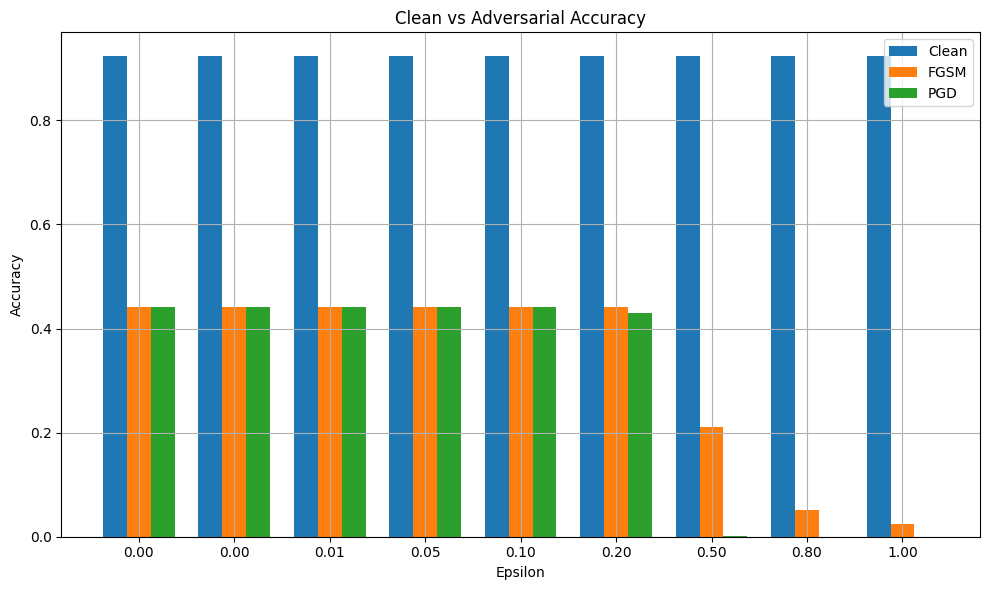

In [20]:
clean_accuracy = 0
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for samples, labels in test_loader:
        samples = samples.type(torch.FloatTensor).cuda()
        labels = labels.cuda()
        outputs = model(samples.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    clean_accuracy = correct / total

# Bar plot
import numpy as np

x_labels = [f"{eps:.2f}" for eps in epsilons]
x = np.arange(len(epsilons))
bar_width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - bar_width, [clean_accuracy]*len(epsilons), width=bar_width, label='Clean')
plt.bar(x, fgsm_accuracies, width=bar_width, label='FGSM')
plt.bar(x + bar_width, pgd_accuracies, width=bar_width, label='PGD')
plt.xticks(x, x_labels)
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Clean vs Adversarial Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
print(f"Clean Accuracy: {clean_accuracy * 100:.2f}%")
for i in range(len(epsilons)):
    print(f"Epsilon: {epsilons[i]}, FGSM Accuracy: {fgsm_accuracies[i] * 100:.2f}%, PGD Accuracy: {pgd_accuracies[i] * 100:.2f}%")


"""
print(f"FGSM Accuracy: {fgsm_accuracies[-1] * 100:.2f}%")
print(f"PGD Accuracy: {pgd_accuracies[-1] * 100:.2f}%")
"""

Clean Accuracy: 92.31%
Epsilon: 0.0001, FGSM Accuracy: 44.13%, PGD Accuracy: 44.13%
Epsilon: 0.001, FGSM Accuracy: 44.13%, PGD Accuracy: 44.13%
Epsilon: 0.01, FGSM Accuracy: 44.13%, PGD Accuracy: 44.13%
Epsilon: 0.05, FGSM Accuracy: 44.13%, PGD Accuracy: 44.13%
Epsilon: 0.1, FGSM Accuracy: 44.13%, PGD Accuracy: 44.13%
Epsilon: 0.2, FGSM Accuracy: 44.13%, PGD Accuracy: 43.03%
Epsilon: 0.5, FGSM Accuracy: 21.00%, PGD Accuracy: 0.20%
Epsilon: 0.8, FGSM Accuracy: 5.12%, PGD Accuracy: 0.00%
Epsilon: 1.0, FGSM Accuracy: 2.44%, PGD Accuracy: 0.00%


'\nprint(f"FGSM Accuracy: {fgsm_accuracies[-1] * 100:.2f}%")\nprint(f"PGD Accuracy: {pgd_accuracies[-1] * 100:.2f}%")\n'